In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn import model_selection

import evopipe
import steps
import warnings

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
filename = 'wilt-train.csv'

data = pd.read_csv(filename, sep=',')
train_X = data[data.columns[1:]]
train_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = train_Y.index
train_Y = pd.Series(le.fit_transform(train_Y), index=ix)


test_filename = 'wilt-test.csv'

data = pd.read_csv(test_filename, sep=',')
test_X = data[data.columns[1:]]
test_Y = data[data.columns[0]]
le = preprocessing.LabelEncoder()

ix = test_Y.index
test_Y = pd.Series(le.fit_transform(test_Y), index=ix)

params = steps.get_params(len(train_X.iloc[0]))

In [6]:
print("Format:")
print("------------")
print("Classifier")
print("score")
print("cross-validation score")
print("GridSearch score")
print("------------")
print()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    for name, cls in steps.clfs.items():
        classif = cls()
        print(classif.__class__.__name__)
        classif.fit(train_X, train_Y)
        print(classif.score(test_X, test_Y))
        print(model_selection.cross_val_score(classif, test_X, test_Y).mean())
        
        pipe_params = params[name]
        gs = model_selection.GridSearchCV(classif, pipe_params, n_jobs=-1, verbose=5)
        gs.fit(train_X, train_Y)
        
        print(gs.best_params_)
        print(gs.score(test_X, test_Y))
        print()

Format:
------------
Classifier
score
cross-validation score
GridSearch score
------------

SVC
0.628
0.626004016064257
Fitting 3 folds for each of 126 candidates, totalling 378 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 378 out of 378 | elapsed:  2.1min finished


{'C': 10, 'gamma': 0.0001, 'tol': 0.0001}
0.858

LogisticRegression
0.65
0.8339309619430102
Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    5.5s finished


{'C': 0.1, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.01}
0.626

Perceptron
0.626
0.6381239242685025
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    3.8s finished


{'alpha': 0.0001, 'n_iter': 1, 'penalty': 'None'}
0.626

SGDClassifier
0.614
0.6435025817555938
Fitting 3 folds for each of 69120 candidates, totalling 207360 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 462 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 1902 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 3918 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 6510 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 9678 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 13422 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 17742 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 22638 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 28110 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 34158 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 40782 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 47982 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 55758 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 64110 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 73038 tasks      | e

{'alpha': 0.01, 'epsilon': 0.1, 'eta0': 0.01, 'l1_ratio': 0, 'learning_rate': 'optimal', 'loss': 'perceptron', 'n_iter': 5, 'penalty': 'l2', 'power_t': 2}
0.626

PassiveAggressiveClassifier
0.628
0.6159160451329125
Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  35 out of  42 | elapsed:    3.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    3.1s finished


{'C': 1.0, 'loss': 'squared_hinge'}
0.626

LinearDiscriminantAnalysis
0.634
0.8659638554216867
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.0s finished


{'shrinkage': 0.1, 'solver': 'lsqr'}
0.626

QuadraticDiscriminantAnalysis
0.78
0.8659877605660738
Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:    3.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.1s finished


{'reg_param': 0.0, 'tol': 0.0001}
0.78

MLPClassifier
0.76
0.6158204245553643
Fitting 3 folds for each of 104976 candidates, totalling 314928 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1654 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 2338 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3094 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3768 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 4434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 5406 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 6450 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 7069 tasks      | elapsed:  7.3min

{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'invscaling', 'learning_rate_init': 0.0001, 'max_iter': 200, 'momentum': 0.9, 'power_t': 0.5, 'solver': 'lbfgs', 'tol': 0.001}
0.626

GaussianNB
0.662
0.6203384968445209
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.1s finished


{}
0.662

DecisionTreeClassifier
0.8
0.8380187416331996
Fitting 3 folds for each of 1920 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 1462 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:   17.3s finished


{'criterion': 'entropy', 'max_depth': 100, 'max_features': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 10}
0.83

KMeans
-4264994.072983537
-2205841.3123105085
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


{}
-4264311.717758957



In [6]:
clf = evopipe.EvoPipeClassifier(steps.preproc, steps.clfs, params, mutpb=0.5, swap_mutpb=0.8, param_mutpb=0.7,
                                ind_mutpb=0.8)
clf.fit(train_X, train_Y, test_X, test_Y)

score = clf.score(test_X, test_Y)
print("\nBest pipeline test score: {}\n".format(score))
/
best_pipes = clf.best_pipelines()

for pipe in best_pipes:
    pipe.fit(train_X, train_Y)
    res_Y = pipe.predict(test_X)
    
    score = metrics.cohen_kappa_score(test_Y, res_Y, weights='quadratic')
    
    pipe_named_steps = []
    for key, val in pipe.steps:
        pipe_named_steps.append(key)       
    print("Kappa: {}, Pipe: {}".format(score, pipe_named_steps))

C:\Anaconda\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'PipeFitness' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Anaconda\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)



Gen 6:

Hall of fame:
[('kBest', {'k': 5}), ('SVC', {'C': 15, 'gamma': 0.0001, 'tol': 0.0001})]
[('SVC', {'C': 15, 'gamma': 0.0001, 'tol': 0.0001})]
[('QDA', {'reg_param': 0.0, 'tol': 0.01})]
[('QDA', {'reg_param': 0.5, 'tol': 0.0001})]
[('PCA', {'n_components': 5, 'whiten': True}), ('SGD', {'penalty': 'elasticnet', 'loss': 'modified_huber', 'n_iter': 100, 'alpha': 0.0001, 'l1_ratio': 1, 'epsilon': 0.5, 'learning_rate': 'optimal', 'eta0': 0.01, 'power_t': 0.5})]

Gen 11:

Hall of fame:
[('kBest', {'k': 5}), ('SVC', {'C': 15, 'gamma': 0.0001, 'tol': 0.0001})]
[('SVC', {'C': 15, 'gamma': 0.0001, 'tol': 0.0001})]
[('QDA', {'reg_param': 0.0, 'tol': 0.01})]
[('QDA', {'reg_param': 0.5, 'tol': 0.0001})]
[('PCA', {'n_components': 5, 'whiten': False}), ('gaussianNB', {})]

Gen 16:

Hall of fame:
[('kBest', {'k': 5}), ('SVC', {'C': 15, 'gamma': 0.0001, 'tol': 0.0001})]
[('SVC', {'C': 15, 'gamma': 0.0001, 'tol': 0.0001})]
[('QDA', {'reg_param': 0.0, 'tol': 0.01})]
[('QDA', {'reg_param': 0.5, 'to

   	                       fitness                        	                       train_test                      
   	------------------------------------------------------	-------------------------------------------------------
gen	var        	avg      	min         	max   	var       	avg      	min        	max    
1  	0.129879   	0.352597 	0           	0.8381	0.0617158 	0.219748 	0          	0.68674
2  	0.0825895  	0.285675 	0           	0.8381	0.0339493 	0.0945999	-0.162857  	0.68674
3  	0.045454   	0.680021 	0.135868    	0.8381	0.0445502 	0.503159 	0          	0.68674
4  	0.104877   	0.534828 	0           	0.8381	0.0503813 	0.342602 	0          	0.68674
5  	0.115556   	0.278211 	0.00388763  	0.8381	0.0895684 	0.194465 	-0.00654786	0.68674
6  	0.0495237  	0.495067 	0           	0.8381	0.0361706 	0.379809 	0          	0.68674
7  	0.134329   	0.2316   	0           	0.8381	0.0922262 	0.183131 	0          	0.68674
8  	0.106797   	0.281207 	0           	0.8381	0.0774515 	0.192456 	0      

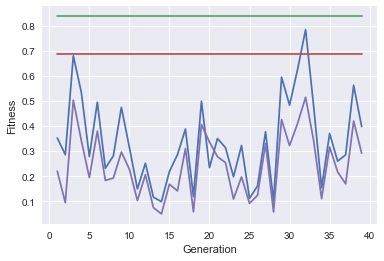

In [7]:
print(clf.logbook)

gen = clf.logbook.select("gen")
avgs, mins, maxs, vars = clf.logbook.chapters["fitness"].select("avg", "min", "max", "var")
avgs_tt, mins_tt, maxs_tt, vars_tt = clf.logbook.chapters["train_test"].select("avg", "min", "max", "var")

sns.set()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(gen, avgs, label='Average')
ax1.set_xlabel("Generation")
ax1.set_ylabel("Fitness")

ax1.plot(gen, maxs, label='Maximum')

ax1.plot(gen, maxs_tt, label='Maximum test')
ax1.plot(gen, avgs_tt, label='Average test')

plt.show()